In [1]:
def OpenFit(file):

    from fitparse import FitFile
    import pandas as pd

    # Open the FIT file
    fit_file = FitFile(file)  # Replace 'your_fit_file.fit' with your file path

    # Parse the file
    fit_file.parse()

    # Extract data from the FIT file
    data = []
    for record in fit_file.get_messages('record'):
        # Extract fields from each record
        record_data = {}
        for field in record:
            record_data[field.name] = field.value
        data.append(record_data)

    # Perform analysis or print data
    return pd.DataFrame(data)

In [2]:
import pandas as pd
    # Function to convert string to time format
def convert_to_time(row):
    parts = row.split(':')
    minutes = int(parts[0])
    seconds = int(float(parts[1]))  # Convert seconds to float first, then to integer
    return pd.Timedelta(minutes=minutes, seconds=seconds)

def intervalExtractor(hrFile, intervalPath):
    intervalFile = pd.read_csv(intervalPath, index_col='Laps')
    # Applying the function to the column and creating a new 'Time_Format' column
    intervalFile['TimeF'] =intervalFile['Time'].apply(convert_to_time)
    # Modify the value using .loc to avoid the SettingWithCopyWarning
    intervalFile.iloc[0, intervalFile.columns.get_loc('TimeF')] += hrFile['timestamp'][0]
    
    intervalFile['TimeF'] = intervalFile['TimeF'].cumsum()
    intervalFile = intervalFile.iloc[:-1]
    return intervalFile


In [3]:
# Creating a class to represent an object
class train5z:
    def __init__(self, hr, pz1, pz2, pz3, pz4, pz5, pmax, Maxhr):
        self.hr = hr
        self.pz1 =pz1 
        self.pz2 =pz2 
        self.pz3 =pz3 
        self.pz4 =pz4 
        self.pz5 =pz5
        self.pmax =pmax
        self.Maxhr = Maxhr  
        
def Hr5ZonesWorkout(hr, df):
    z1l= hr*.50
    z1u= hr*.60
    z2l= hr*.60
    z2u= hr*.70
    z3l= hr*.70
    z3u= hr*.80
    z4l= hr*.80
    z4u= hr*.90
    z5l= hr*.90
    z5u= hr


    totalhr=len(df)

    # Count measurements in Moderate and Vigorous zones
    z1 = ((df['heart_rate'] >= z1l) & (df['heart_rate'] < z1u)).sum()
    z2 = ((df['heart_rate'] >= z2l) & (df['heart_rate'] < z2u)).sum()
    z3 = ((df['heart_rate'] >= z3l) & (df['heart_rate'] < z3u)).sum()
    z4 = ((df['heart_rate'] >= z4l) & (df['heart_rate'] < z4u)).sum()
    z5 = ((df['heart_rate'] >= z5l) & (df['heart_rate'] < z5u)).sum()
    ov = ((df['heart_rate'] > z5u)).sum()
    Maxhr = df['heart_rate'].max() 

    
    pz1 = z1/totalhr*100
    pz2 = z2/totalhr*100
    pz3 = z3/totalhr*100
    pz4 = z4/totalhr*100
    pz5= z5/totalhr*100
    pmax = ov/totalhr*100

    return train5z(hr,pz1, pz2, pz3, pz4, pz5, pmax, Maxhr)

In [4]:
def Hr5Zones(hr, hrClass):
    z1l= round(hr*.50)
    z1u= round(hr*.60)
    z2l= round(hr*.60)
    z2u= round(hr*.70)
    z3l= round(hr*.70)
    z3u= round(hr*.80)
    z4l= round(hr*.80)
    z4u= round(hr*.90)
    z5l= round(hr*.90)
    z5u= hr

    if (hrClass.Maxhr > z5u):
        return{
            # Moderate Zone
            'Z1': (z1l, z1u),
            # Vigorous Zone
            'Z2': (z2l, z2u),
            # Vigorous Zone
            'Z3': (z3l, z3u),
            # Vigorous Zone
            'Z4': (z4l, z4u),
            # Vigorous Zone
            'Z5': (z5l, z5u),
            # Over Z5 zone
            'OV': (z5u, hrClass.Maxhr)  
        } 
    else :
        return{
                # Moderate Zone
        'Z1': (z1l, z1u),
        # Vigorous Zone
        'Z2': (z2l, z2u),
        # Vigorous Zone
        'Z3': (z3l, z3u),
        # Vigorous Zone
        'Z4': (z4l, z4u),
        # Vigorous Zone
        'Z5': (z5l, z5u),
        # Over Z5 zone
        'OV': (z5u, z5u) 
        }

In [5]:
def PlotWorkout5Zones(hr, hrSource, timerSource):    
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter

    hrFile = OpenFit(hrSource)
    Class_values = Hr5ZonesWorkout(hr, hrFile)
    zones = Hr5Zones(hr, Class_values)
    intervalFile = intervalExtractor(hrFile, timerSource)

    # Plotting heart rate data
    plt.figure(figsize=(10, 6))

    plt.plot(hrFile['timestamp'], hrFile['heart_rate'], linestyle='-', label='Heart Rate', color='red')
    
    # Overlaying zones on the plot
    plt.fill_between(hrFile['timestamp'], zones['Z1'][0], zones['Z1'][1],
                    color='gray', alpha=0.3, label='Warm up')
    plt.fill_between(hrFile['timestamp'], zones['Z2'][0], zones['Z2'][1],
                    color='blue', alpha=0.3, label='Easy')
    plt.fill_between(hrFile['timestamp'], zones['Z3'][0], zones['Z3'][1],
                    color='green', alpha=0.3, label='Aerobic')
    plt.fill_between(hrFile['timestamp'], zones['Z4'][0], zones['Z4'][1],
                    color='orange', alpha=0.3, label='Threshold')
    plt.fill_between(hrFile['timestamp'], zones['Z5'][0], zones['Z5'][1],
                    color='red', alpha=0.3, label='Maximum')                    
    plt.fill_between(hrFile['timestamp'], zones['OV'][0], zones['OV'][1],
                    color='#750505', alpha=0.3, label='OverMax')

    insights_text = f'''
    HR PCT% on this Session:
    Zone 1: {round(Class_values.pz1)}%
    Zone 2: {round(Class_values.pz2)}%
    Zone 3: {round(Class_values.pz3)}%
    Zone 4: {round(Class_values.pz4)}%
    Zone 5: {round(Class_values.pz5)}%
    Over Z5: {round(Class_values.pmax)}%
    MaxHr: {round(Class_values.Maxhr)}
    '''
    # Get the limits of the plot's data
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()

    # Calculate coordinates relative to the data limits
    text_x = x_min + 0.6 * (x_max - x_min)  # 10% from the left
    text_y = y_min + 0.05 * (y_max - y_min)  # 90% from the bottom

    # Add the text box
    plt.text(text_x, text_y, insights_text, fontsize=10, bbox=dict(facecolor='lightblue', alpha=0.5))

    # Plotting vertical lines at cumulative time points
    for time_point in intervalFile['TimeF']:
        plt.axvline(x=time_point, color='black', linestyle='--', alpha=0.5)

    # Formatting
    plt.xlabel('Time')
    plt.ylabel('Heart Rate')
    plt.title('Heart Rate Variation over Time with Zones')
    plt.grid(True)
    plt.legend()
    date_format = DateFormatter('%H:%M:%S')  # Format for hours:minutes:seconds
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)

    plt.tight_layout()

    # Show plot
    plt.show()



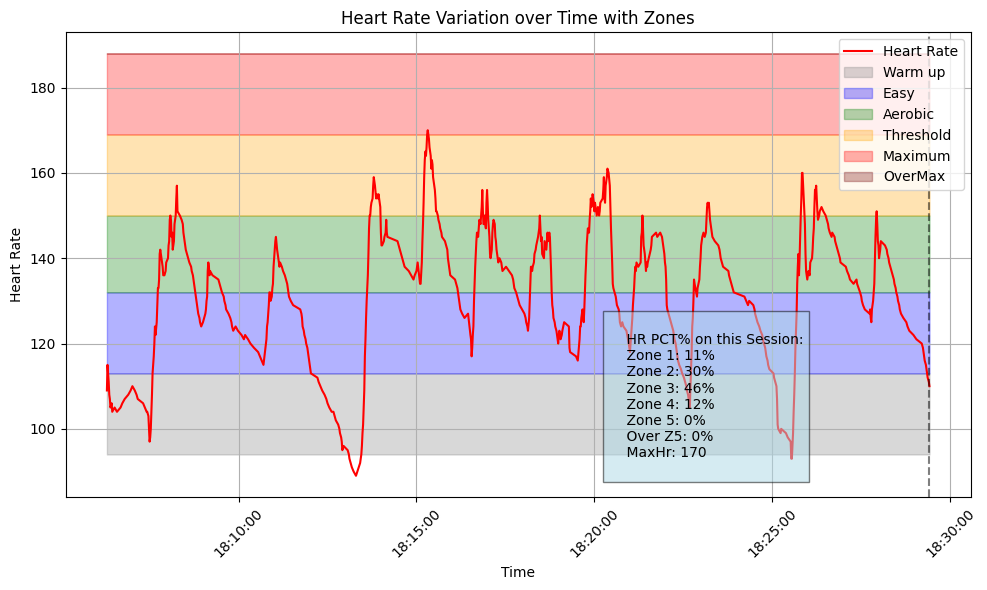

In [6]:
PlotWorkout5Zones(188,'12731112031_ACTIVITY.fit', 'activity_12731112031.csv')

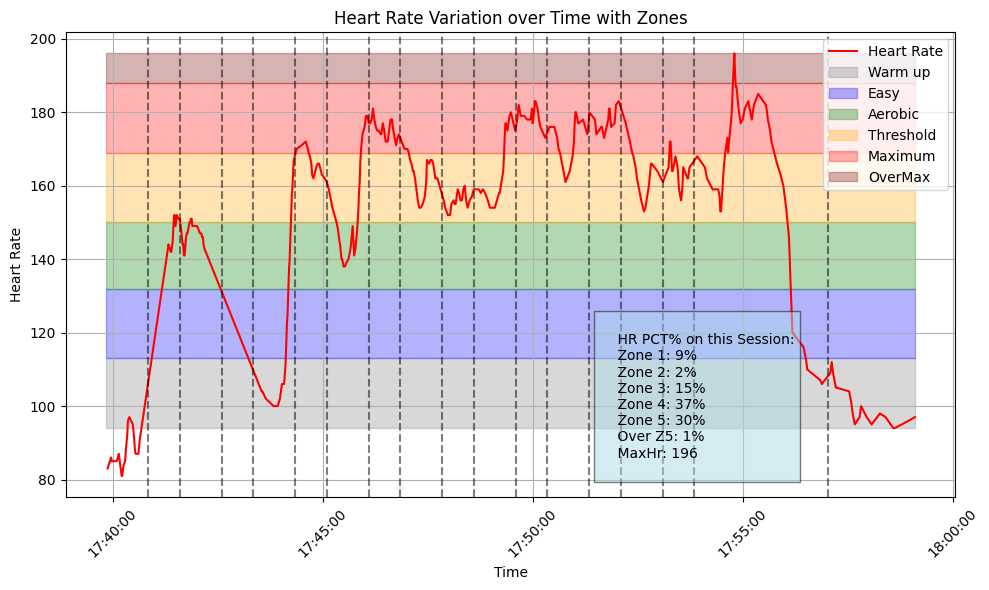

In [7]:
PlotWorkout5Zones(188,'12782855903_ACTIVITY.fit', 'activity_12782855903.csv')

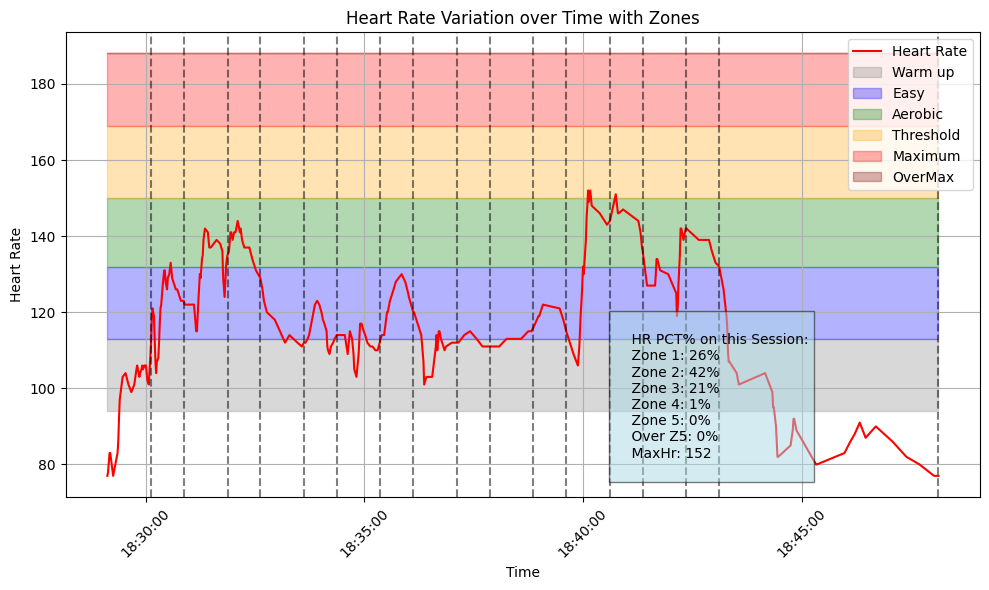

In [8]:
PlotWorkout5Zones(188,'12822011162_ACTIVITY.fit', 'activity_12822011162.csv')

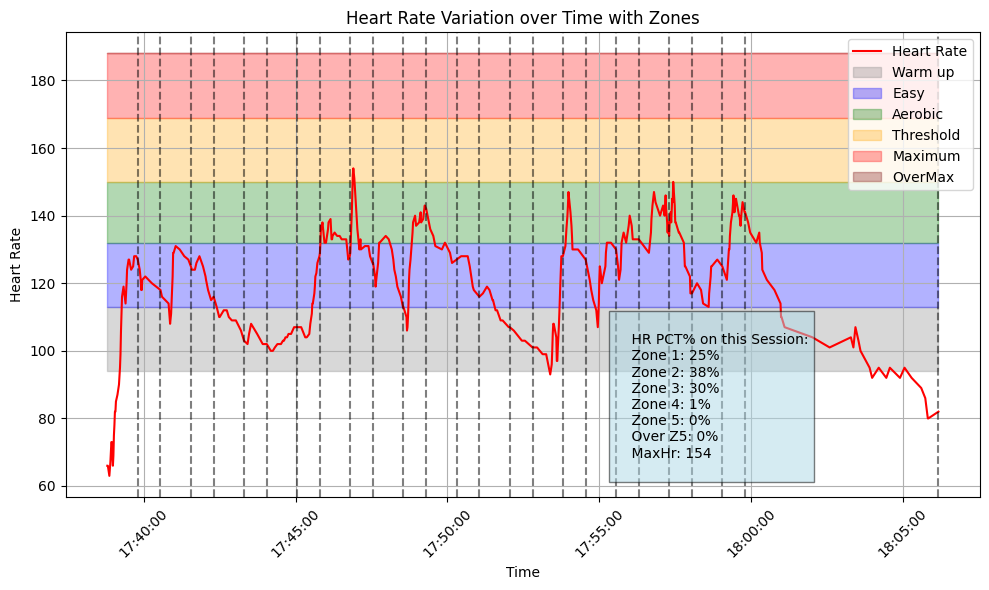

In [9]:
PlotWorkout5Zones(188,'12885161274_ACTIVITY.fit', 'activity_12885161274.csv')